<h1>TKN Training Notebook</h1>
This notebook is used to train the network

In [1]:
import numpy as np
import pandas as pd
import os, datetime
import time
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import models

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.5.0-dev20201027
Num GPUs Available:  1


<h2>Data Processing</h2>

In [2]:
data_path = '~/data/daily-min-temperatures.csv'

#TODO: get data and read more data
# df = pd.read_csv(data_path, delimiter=',', usecols=['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT'],skiprows=[i for i in range(1,200000)], nrows=1000000)
df = pd.read_csv(data_path, delimiter=',')

# Replace 0 to avoid dividing by 0 later on
# TODO: SHOULD USE FFILL, but doesn't work if first entry is 0
# or IDEALLY, USE SOME METHOD TO INDICATE VOLUME IS 0
df['Temp'].replace(to_replace=0, method='ffill', inplace=True)
# df['PRC'].replace(to_replace=0, method='ffill', inplace=True)
# df.sort_values(by=['date'], inplace=True)

# df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
# #TODO: remove rolling mean
# df[['PRC', 'VOL']] = df[['PRC', 'VOL']].rolling(5).mean() 

In [3]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
df.tail()

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


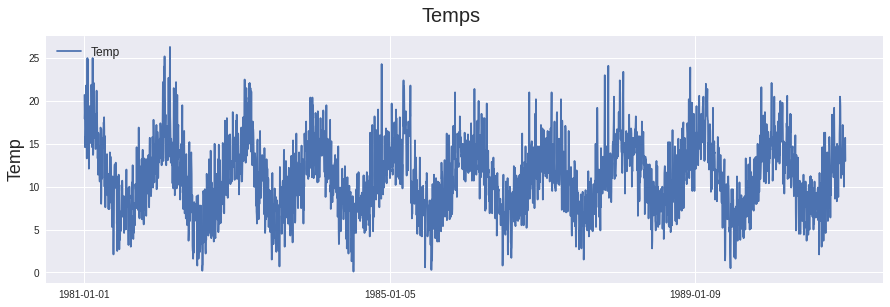

In [5]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Temps", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Temp'], label='Temp')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Temp', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

In [6]:
# '''Calculate percentage change'''

# df['Temp'] = df['Temp'].pct_change()

# df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

# '''Normalize price columns'''

# min_t = min(df['Temp'])
# max_t = max(df['Temp'])

# print(min_t)
# print(max_t)

# # Min-max normalize price columns (0-1 range)
# df['Temp'] = (df['Temp'] - min_t) / (max_t - min_t)


'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date, time, symbol column
df_train.drop(columns=['Date'], inplace=True)
'''Normalize volume column'''

df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.tail()

Training data shape: (2920, 1)
Validation data shape: (365, 1)
Test data shape: (365, 1)


,Temp
2915,9.5
2916,12.9
2917,12.9
2918,14.8
2919,14.1


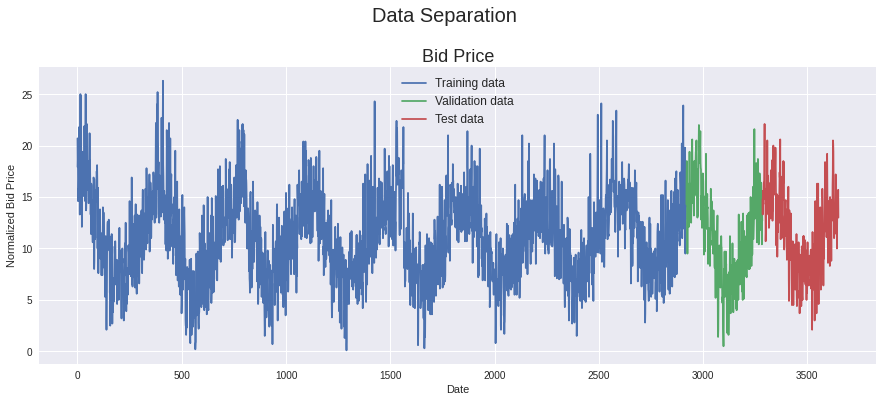

In [7]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Temp'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Temp'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Temp'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Bid Price')
ax1.set_title("Bid Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)


In [8]:
seq_len=128

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append([train_data[i]]) #Value of col 0 and 2 (BID and ASK)
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append([val_data[i]])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append([test_data[i]])  
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (2792, 128, 1) (2792, 1, 1)
Validation set shape (237, 128, 1) (237, 1, 1)
Testing set shape (237, 128, 1) (237, 1, 1)


<h2>Loss Function  and Optimizer</h2>

In [9]:
num_layers = 3
d_model = 16
dff = 128
num_heads = 16

dropout_rate = 0.01

In [10]:
#CUSTOM ADAM BASED ON https://arxiv.org/abs/1706.03762
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [11]:
learning_rate = CustomSchedule(d_model, warmup_steps=10)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [12]:
loss_object = tf.keras.losses.MeanSquaredError()

def loss_function(real, pred):
  loss_ = loss_object(real, pred)
  
  return tf.reduce_sum(loss_)

In [13]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [14]:
model = models.TKN_Basic(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, input_dim=1, output_dim=1,
              maximum_position_encoding=5000, rate=dropout_rate)

In [15]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

#if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [16]:
model.compile(optimizer, loss_function)
history = model.fit(X_train, y_train, 
                    batch_size=400, 
                    epochs=50, 
                    callbacks=[],
                    validation_data=(X_val, y_val))

Epoch 1/50
7/7 [==============================] - 4s 198ms/step - loss: 144.7445 - val_loss: 237.9160
Epoch 2/50
7/7 [==============================] - 1s 101ms/step - loss: 105.4745 - val_loss: 14.7821
Epoch 3/50
7/7 [==============================] - 1s 102ms/step - loss: 32.1690 - val_loss: 14.4520
Epoch 4/50
7/7 [==============================] - 1s 101ms/step - loss: 19.9999 - val_loss: 13.4370
Epoch 5/50
7/7 [==============================] - 1s 102ms/step - loss: 18.9029 - val_loss: 16.9615
Epoch 6/50
7/7 [==============================] - 1s 101ms/step - loss: 16.4355 - val_loss: 23.1758
Epoch 7/50
7/7 [==============================] - 1s 102ms/step - loss: 16.1822 - val_loss: 15.5385
Epoch 8/50
7/7 [==============================] - 1s 105ms/step - loss: 16.6013 - val_loss: 16.0804
Epoch 9/50
7/7 [==============================] - 1s 113ms/step - loss: 15.9686 - val_loss: 21.8408
Epoch 10/50
7/7 [==============================] - 1s 106ms/step - loss: 16.6678 - val_loss: 15.7

In [17]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

In [18]:
#ckpt_manager.save()

In [19]:
train_pred

array([[11.603103],
       [11.603103],
       [11.603103],
       ...,
       [11.603101],
       [11.603101],
       [11.603101]], dtype=float32)

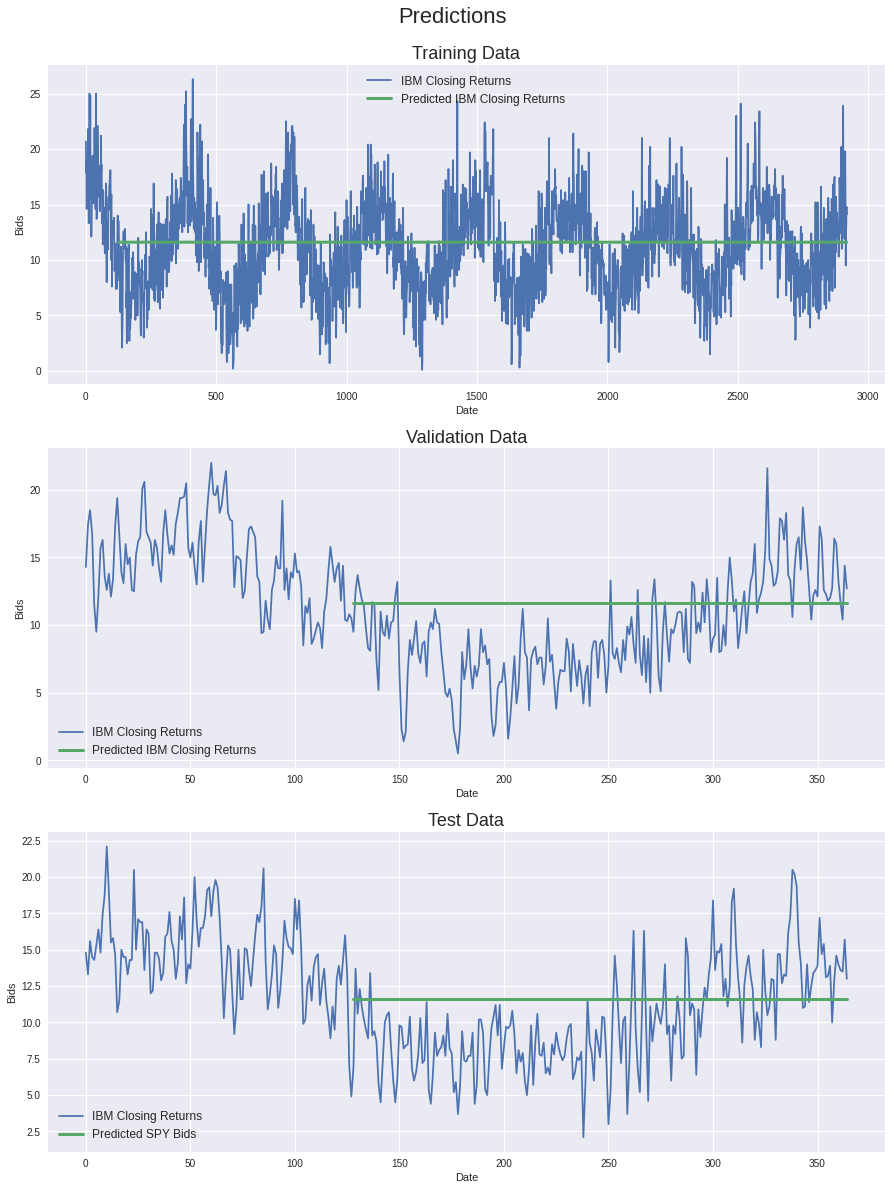

In [20]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Predictions", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 0], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred[:,0], linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Bids')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 0], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred[:,0], linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Bids')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 0], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred[:,0], linewidth=3, label='Predicted SPY Bids')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Bids')
ax31.legend(loc="best", fontsize=12)
